In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import RMSprop
import numpy as np
import random
import sys


In [5]:
#LOAD T
#Save notepad as UTF-8 (select from dropdown during saving)
filename = "/content/drive/MyDrive/236-0.txt"
raw_text = open(filename, 'r', encoding='utf-8').read()
raw_text = raw_text.lower()
print(raw_text[0:1000])


﻿
it was seven o’clock of a very warm evening in the seeonee hills when
father wolf woke up from his day’s rest, scratched himself, yawned, and
spread out his paws one after the other to get rid of the sleepy feeling
in their tips. mother wolf lay with her big gray nose dropped across her
four tumbling, squealing cubs, and the moon shone into the mouth of the
cave where they all lived. “augrh!” said father wolf. “it is time to
hunt again.” he was going to spring down hill when a little shadow with
a bushy tail crossed the threshold and whined: “good luck go with you, o
chief of the wolves. and good luck and strong white teeth go with noble
children that they may never forget the hungry in this world.”

it was the jackal--tabaqui, the dish-licker--and the wolves of india
despise tabaqui because he runs about making mischief, and telling
tales, and eating rags and pieces of leather from the village
rubbish-heaps. but they are afraid of him too, because tabaqui, more
than anyone else in t

PREPROCESSING

In [6]:
#CLEAN TEXT
#Remove numbers
raw_text = ''.join(c for c in raw_text if not c.isdigit())


In [7]:
#How many total characters do we have in our training text?
chars = sorted(list(set(raw_text))) #List of every character

In [8]:
chars

['\n',
 ' ',
 '!',
 '$',
 '%',
 '(',
 ')',
 '*',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '?',
 '@',
 '[',
 ']',
 '`',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '‘',
 '’',
 '“',
 '”',
 '\ufeff']

In [9]:
#Character sequences must be encoded as integers. 
#Each unique character will be assigned an integer value. 
#Create a dictionary of characters mapped to integer values
char_to_int = dict((c, i) for i, c in enumerate(chars))


In [10]:
char_to_int

{'\n': 0,
 ' ': 1,
 '!': 2,
 '$': 3,
 '%': 4,
 '(': 5,
 ')': 6,
 '*': 7,
 ',': 8,
 '-': 9,
 '.': 10,
 '/': 11,
 ':': 12,
 ';': 13,
 '?': 14,
 '@': 15,
 '[': 16,
 ']': 17,
 '`': 18,
 'a': 19,
 'b': 20,
 'c': 21,
 'd': 22,
 'e': 23,
 'f': 24,
 'g': 25,
 'h': 26,
 'i': 27,
 'j': 28,
 'k': 29,
 'l': 30,
 'm': 31,
 'n': 32,
 'o': 33,
 'p': 34,
 'q': 35,
 'r': 36,
 's': 37,
 't': 38,
 'u': 39,
 'v': 40,
 'w': 41,
 'x': 42,
 'y': 43,
 'z': 44,
 '‘': 45,
 '’': 46,
 '“': 47,
 '”': 48,
 '\ufeff': 49}

In [11]:
#Do the reverse so we can print our predictions in characters and not integers
int_to_char = dict((i, c) for i, c in enumerate(chars))

In [12]:
# summarize the data
n_chars = len(raw_text)
n_vocab = len(chars)
print("Total Characters in the text; corpus length: ", n_chars)
print("Total Vocab: ", n_vocab)

Total Characters in the text; corpus length:  291499
Total Vocab:  50


In [13]:
#Now that we have characters we can create input/output sequences for training
#for LSTM input and output can be sequences... hence the term seq2seq


seq_length = 60  #Length of each input sequence
step = 10   #Instead of moving 1 letter at a time, try skipping a few. 
sentences = []    # X values (Sentences)
next_chars = []   # Y values. The character that follows the sentence defined as X
for i in range(0, n_chars - seq_length, step):  #step=1 means each sentence is offset just by a single letter
    sentences.append(raw_text[i: i + seq_length])  #Sequence in
    next_chars.append(raw_text[i + seq_length])  #Sequence out
n_patterns = len(sentences)    
print('Number of sequences:', n_patterns)

Number of sequences: 29144


In [15]:
#Have a look at sentences and next_chars to see the continuity...
############################



# reshape input to be [samples, time steps, features]

#time steps = sequence length
#features = numbers of characters in our vocab (n_vocab)
#Vectorize all sentences: there are n_patterns sentences.
#For each sentence we have n_vocab characters available for seq_length
#Vectorization returns a vector for all sentences indicating the presence or absence 
#of a character. 

x = np.zeros((len(sentences), seq_length, n_vocab), dtype=np.bool)
y = np.zeros((len(sentences), n_vocab), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_to_int[char]] = 1
    y[i, char_to_int[next_chars[i]]] = 1
    
print(x.shape)
print(y.shape)

#print(y[0:10])


<ipython-input-15-444fd40eaaf2>:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.zeros((len(sentences), seq_length, n_vocab), dtype=np.bool)
<ipython-input-15-444fd40eaaf2>:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.zeros((len(sentences), n_vocab), dtype=np.bool)


(29144, 60, 50)
(29144, 50)


In [16]:
#Basic model with one LSTM
# build the model: a single LSTM

model = Sequential()
model.add(LSTM(128, input_shape=(seq_length, n_vocab)))
model.add(Dense(n_vocab, activation='softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               91648     
                                                                 
 dense (Dense)               (None, 50)                6450      
                                                                 
Total params: 98,098
Trainable params: 98,098
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [17]:
# Deeper model woth 2 LSTM
#To stack LSTM layers, we need to change the configuration of the prior 
#LSTM layer to output a 3D array as input for the subsequent layer.
#We can do this by setting the return_sequences argument on the layer to True 
#(defaults to False). This will return one output for each input time step and provide a 3D array.
#Below is the same example as above with return_sequences=True.

In [18]:
model = Sequential()
model.add(LSTM(128, input_shape=(seq_length, n_vocab), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(n_vocab, activation='softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 60, 128)           91648     
                                                                 
 dropout (Dropout)           (None, 60, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                6450      
                                                                 
Total params: 229,682
Trainable params: 229,682
Non-trainable params: 0
_________________________________________________________________


In [19]:
from keras.callbacks import ModelCheckpoint

filepath="saved_weights/saved_weights-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint]


In [20]:
history = model.fit(x, y,
          batch_size=128,
          epochs=50,   
          callbacks=callbacks_list)

model.save('my_saved_weights_jungle_book_50epochs.h5')

Epoch 1/50
228/228 [==============================] - ETA: 0s - loss: 2.6589
Epoch 1: loss improved from inf to 2.65892, saving model to saved_weights/saved_weights-01-2.6589.hdf5
228/228 [==============================] - 12s 18ms/step - loss: 2.6589
Epoch 2/50
228/228 [==============================] - ETA: 0s - loss: 2.1791
Epoch 2: loss improved from 2.65892 to 2.17911, saving model to saved_weights/saved_weights-02-2.1791.hdf5
228/228 [==============================] - 3s 12ms/step - loss: 2.1791
Epoch 3/50
227/228 [============================>.] - ETA: 0s - loss: 1.9907
Epoch 3: loss improved from 2.17911 to 1.99067, saving model to saved_weights/saved_weights-03-1.9907.hdf5
228/228 [==============================] - 3s 12ms/step - loss: 1.9907
Epoch 4/50
225/228 [============================>.] - ETA: 0s - loss: 1.8689
Epoch 4: loss improved from 1.99067 to 1.86905, saving model to saved_weights/saved_weights-04-1.8690.hdf5
228/228 [==============================] - 3s 11ms/ste

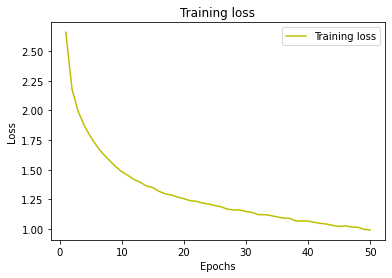

In [21]:
from matplotlib import pyplot as plt
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
#Generate characters 
#We must provide a sequence of seq_lenth as input to start the generation process

#The prediction results is probabilities for each of the 48 characters at a specific
#point in sequence. Let us pick the one with max probability and print it out.
#Writing our own softmax function....

def sample(preds):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds) #exp of log (x), isn't this same as x??
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1) 
    return np.argmax(probas)

In [23]:
#Prediction
# load the network weights
filename = "my_saved_weights_jungle_book_50epochs.h5"
model.load_weights(filename)

#Pick a random sentence from the text as seed.
start_index = random.randint(0, n_chars - seq_length - 1)

#Initiate generated text and keep adding new predictions and print them out
generated = ''
sentence = raw_text[start_index: start_index + seq_length]
generated += sentence

print('----- Seed for our text prediction: "' + sentence + '"')
#sys.stdout.write(generated)

----- Seed for our text prediction: "eavy, as big, and as fierce as his
father. “give me another "


In [26]:
start_index

152586

In [25]:
for i in range(400):   # Number of characters including spaces
    x_pred = np.zeros((1, seq_length, n_vocab))
    for t, char in enumerate(sentence):
        x_pred[0, t, char_to_int[char]] = 1.

    preds = model.predict(x_pred, verbose=0)[0]
    next_index = sample(preds)
    next_char = int_to_char[next_index]

    generated += next_char
    sentence = sentence[1:] + next_char

    sys.stdout.write(next_char) # writing one character at a time 
    sys.stdout.flush()
print()

en
bround,
but, and the beather when the monkeys gun and shoulder fater, him in a little parces and seephing, it smust he had

<ipython-input-22-8e775d08c2e9>:10: RuntimeWarning: divide by zero encountered in log
  preds = np.log(preds)



never we rulled of the sturned up him the monkeys been tway to do.

“that little balk not have been the
, banglight!” said the camel run down to do ir wolves. but before what they call that yeur in the lames from buck have chind, and the troward. flicked of the beafs aulter


# New section